# Loading venv and importing packages

We will be using a well-known RL library called Stable Baselines 3 during this excercise for their implementations of advanced RL algorithms. The library is based on PyTorch. To save you all some setting up time a virtual environment has been prepared for you. Running the code below will activate it in this notebook and allow you to access all necessary packages.

In [1]:
import os
import site
import sys
venv_location = '../venv' #'./hansOn-venv' #/eos/project/s/sy-rf-br/Training/hansOn-venv'
venv_site_packages = os.path.join(
        venv_location, 'lib', 'python{}.{}'.format(*sys.version_info), 'site-packages')
    
# If the venv site-packages doesn't exist on the path already, insert it right
# before the underlying Python's site-packages.
if venv_site_packages not in sys.path:
    posn = -1
    site_package_dirs = [
        index for index, path in enumerate(sys.path) if path.endswith('site-packages')]
    print
    if site_package_dirs:
        posn = site_package_dirs[0]
        
    sys.path.insert(posn, venv_site_packages)
#     print(venv_site_packages)


In [1]:
import site
import sys
from tqdm import tqdm

# Make sure user path to venv site-packages is in system path
user_site = site.getusersitepackages()
if user_site not in sys.path:
    sys.path.append(user_site)

In [2]:
user_site

'/eos/user/j/joelaxel/.local/lib/python3.11/site-packages'

In [3]:
!pip install --user -U stable-baselines3

  Using cached stable_baselines3-2.5.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached gymnasium-1.0.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
Using cached stable_baselines3-2.5.0-py3-none-any.whl (183 kB)
Using cached gymnasium-1.0.0-py3-none-any.whl (958 kB)
Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
DEPRECATION: gosam 2.1.1-4b98559 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of gosam or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [9]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
from utils import transform_profile, isolate_bunches_from_dm_profile
from datamatrix_lookup_class_double import Datamatrix_lookup_class_double

import copy
import random
import gymnasium as gym



### Initialize the data provider class to use for illustrative plots in the introduction
### This class can provide you with simulated tomoscope acquisitions for phase offsets in 
### the range [-45,45] degrees in the h=42 harmonic.

data_class = Datamatrix_lookup_class_double()

Data dictionary compiled.


# Introduction

In this notebook we will attempt to train an agent to optimize an RF double splitting (the first part of the quadruple splitting in nominal LHC-type beams in the PS). The optimization problem is one-dimensional, with only one free variable in the phase offset of the $h=42$ cavity. Depending on the phase setting, the splitting will be biased towards one direction and one bunch will contain more particles than the other. The end goal of the optimization is to minimize the differences between the final bunches.

## The double splitting: some background

As an example problem we will be using an RF-manipulation that is done in the PS during creation of LHC-type beams: a double-splitting. In short, it constitutes taking one bunch placed in a single RF-bucket, and splitting it into two perfectly equal new bunches in their own respective buckets. By equal, we mean that they have the same characteristics; same bunch length, intensity, emmitance etc. In practice this splitting is done by lowering the voltage of the initial RF-cavity (in this case the cavity with harmonic h=21) while raising the voltage of the next one (of double harmonic number, h=42). In so doing we double the amounts of buckets that are available in the accelerator and if done correctly, split the initial bunch into two. 

However, if the timing between the two RF-cavities is not properly aligned the two end bunches will look very different; you end up with more particles and different characteristics in one bucket compared to the other. This misalignment can be considered a phase offset between the phases of the two RF cavities, and when optimized the phase offset should be zero. This offset will be the parameter that we train our networks to predict, given certain characteristics of the current splitting, so that one would be able to correct it easily.

## The dataset

In order to facilitate the optimization we have our simulated dataset of observations. It is from these observations we need to define some form of metric to determine whether a splitting is good or bad, which could then be used either to guide an optimization algorithm or, as in this notebook, to define a reward to our agents.

Due to the time-consuming nature of performing tracking simulations over 10s of thousands turns and the large amounts of training steps generally required in RL, it is not feasible to simulate each function evaluation during training. Because of this a pre-simulated dataset is provided, from which we will sample our datapoints. This does however introduce a few additional challenges that must be considered, e.g.:

- **Handling of points outside the dataset** - handled in the environment
- **Interpolation between simulated datapoints** - handled by the data class

The dataset was created by simulating 361 different phase offsets linearly spaced between -45 and 45 degrees and saving the final bunch lengths, the bunch profile, and the full datamatrix of profiles. To begin with, we will be using primarily the final bunch profiles and their extracted characteristics (such as relative bunch length/intensity).

### Using the data_class and some example profiles

The data_class most important functions are:
- <code>get_interpolated_profile(phase)</code> - Returns the final profile after a splitting with the phase offset <code>phase</code>
- <code>get_interpolated_matrix(phase)</code> - Returns the entire bunch evolution over the course of the splitting with the phase offset <code>phase</code>

Run the code below to see some plots of bunch evolutions and profiles for different phase offsets. 

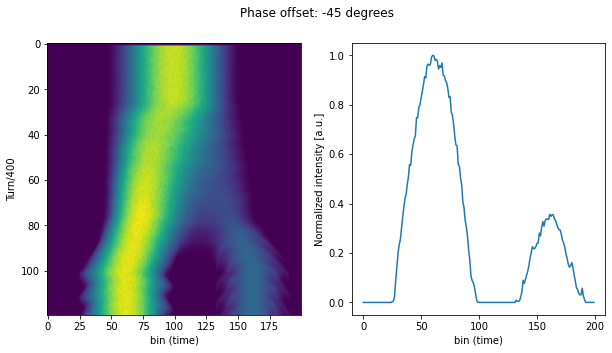

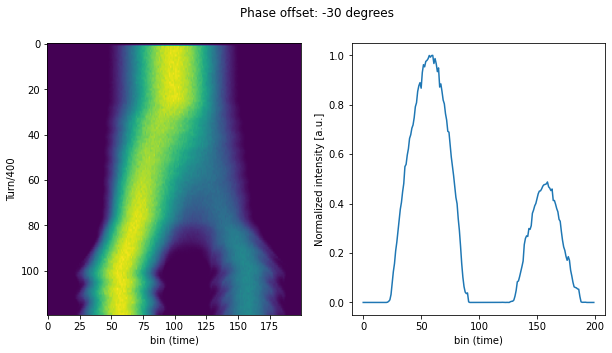

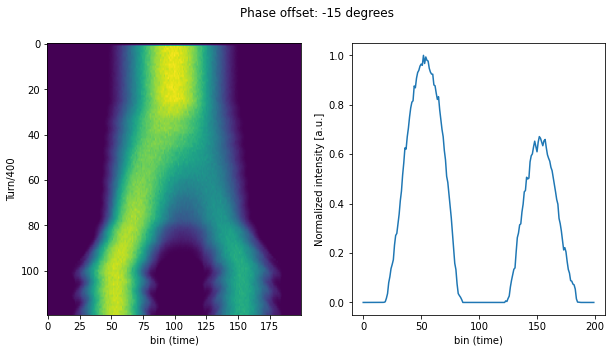

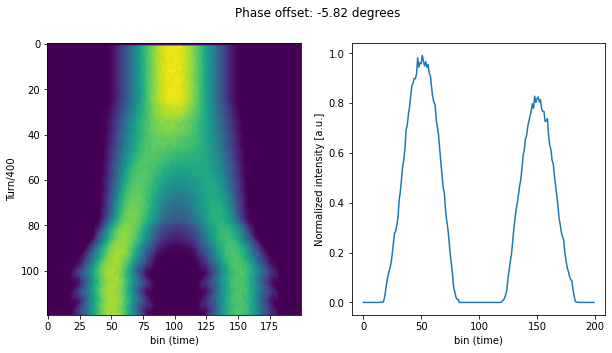

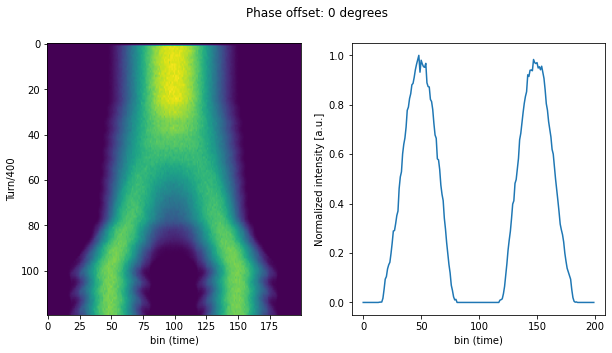

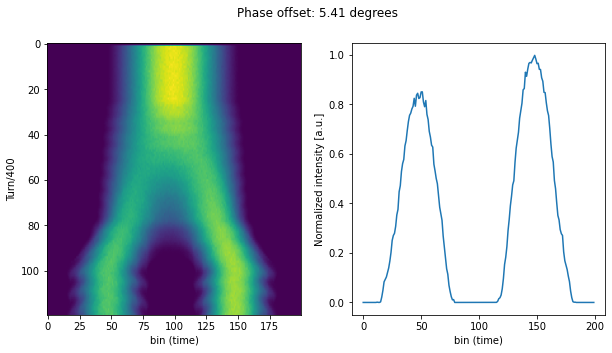

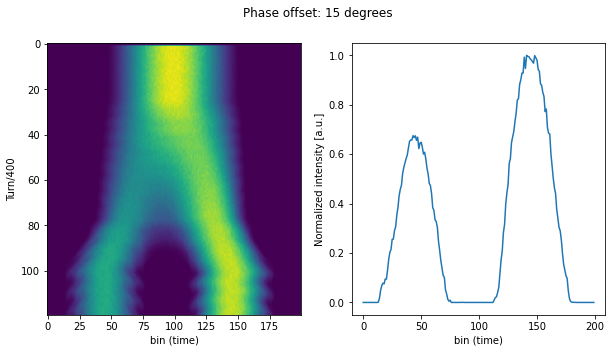

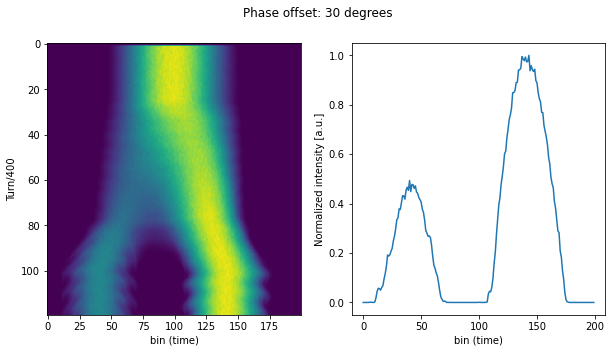

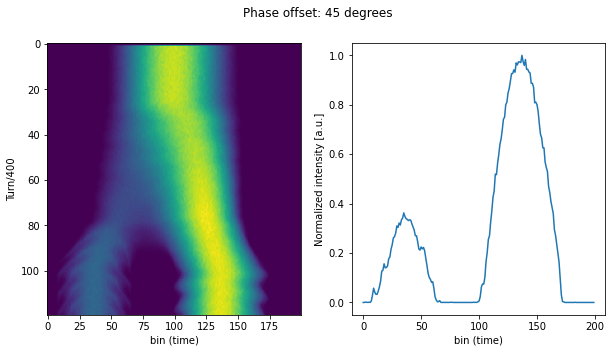

In [10]:
# Examples of using the dataclass and observing the dataset

example_phase_offsets = [-45, -30, -15,-5.82, 0, 5.41, 15, 30, 45] # some example offsets, and some phases requiring interpolation.

for phase in example_phase_offsets:
    # Load interpolated datamatrix or profile
    datamatrix = data_class.get_interpolated_matrix(phase)
    profile = data_class.get_interpolated_profile(phase)
    plt.figure(figsize=(10,5))
    plt.suptitle(f'Phase offset: {phase} degrees')
    plt.subplot(121)
    plt.xlabel("bin (time)")
    plt.ylabel("Turn/400")
    plt.imshow(datamatrix,aspect='auto')
    plt.subplot(122)
    plt.plot(profile)
    plt.xlabel("bin (time)")
    plt.ylabel("Normalized intensity [a.u.]")

## Minor data augmentation
The profiles generated by our simulations are much less noisy than real data from the machine. To make our data more similar to a real datapoint, we also have a <code>transform_profile(profile)</code> function that will add some noise to our data.

Run the next cell to see the slightly noisy profiles.

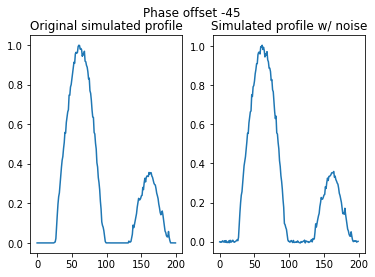

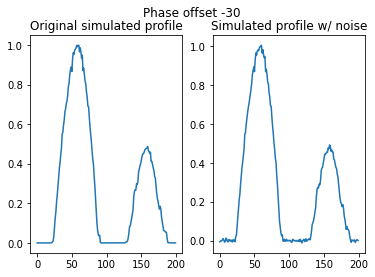

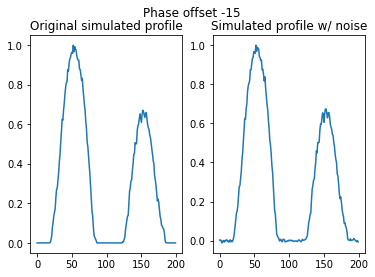

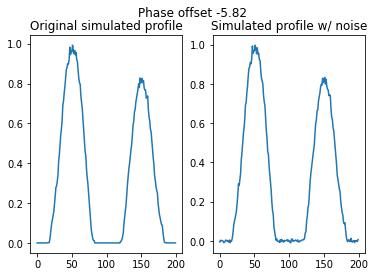

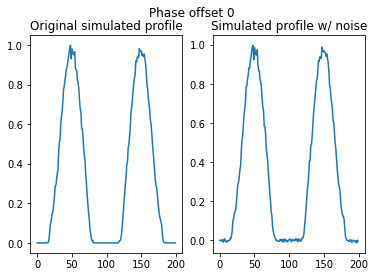

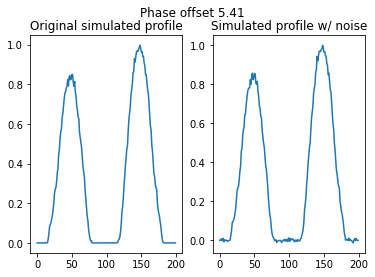

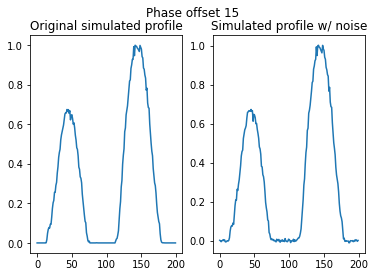

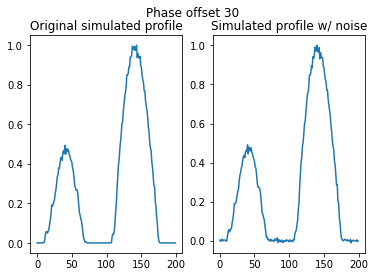

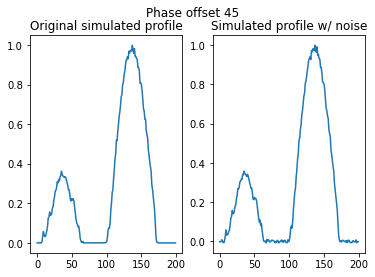

In [11]:
# Examples of using the dataclass and observing the dataset

for phase in example_phase_offsets:
    profile = data_class.get_interpolated_profile(phase)
    noisy_profile = transform_profile(profile)
    plt.figure()
    plt.suptitle(f'Phase offset {phase}')
    plt.subplot(121)
    plt.title('Original simulated profile')
    plt.plot(profile)
    
    plt.subplot(122)
    plt.title('Simulated profile w/ noise')

    plt.plot(noisy_profile)

## Calculating bunch intensities and bunch lengths

From these profiles, we can also calculate even more specific bunch characteristics.

A function called <code>isolate_bunches_from_dm_profile</code> is provided to help you get the relative bunch lengths and intensities of your two bunches. It basically works by finding the center of each bunch, gathering a set number of bins around each center and defining this as your isolated bunch profile. In the process, it also outputs the Full Width at Half Maximum (FWHM) bunch lengths and the intensity of the bunches (the integral of the isolated bunch).

Run the cell below to see an example.

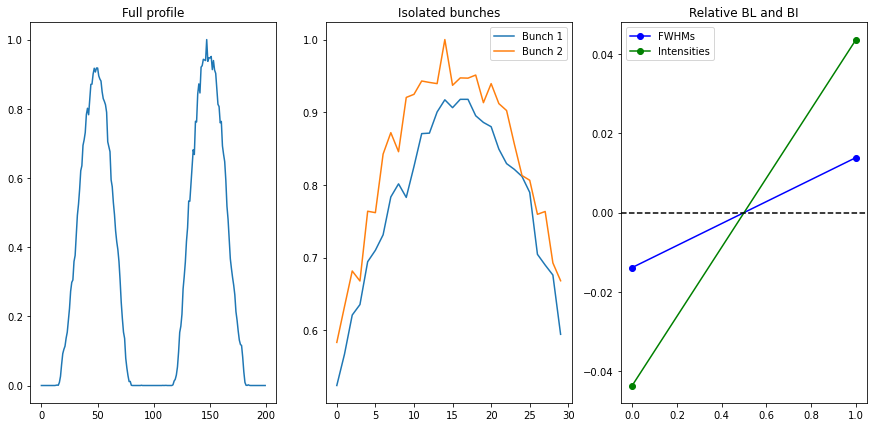

In [12]:
# To do some analysis based on a profile, some additional utility functions are available
from utils import profile_reward_quad, isolate_bunches_from_dm_profile

profile = data_class.get_interpolated_profile(2)
bunches, fwhms, intensities = isolate_bunches_from_dm_profile(profile, intensities=True, rel=True, plot_found_bunches=False)


# Standardization/normalization
fwhms = fwhms-np.mean(fwhms) # The FWHMs are returned normalized, but need to be centered around zero
intensities = intensities / max(intensities) # The intensities are normalized, and centered around zero
intensities = intensities - np.mean(intensities)

### Plotting
plt.figure(figsize=(15,7))
plt.subplot(131)
plt.title('Full profile')
plt.plot(profile)
plt.subplot(132)
plt.title('Isolated bunches')
plt.plot(bunches[0],label='Bunch 1')
plt.plot(bunches[1],label='Bunch 2')
plt.legend()
plt.subplot(133)
plt.title('Relative BL and BI')
plt.plot(fwhms, 'bo-', label='FWHMs')
plt.plot(intensities, 'go-', label='Intensities')
plt.axhline(0, color='k',linestyle='--')
plt.legend()

### Initial suggestion for state and difference estimate

To simplify your initial attempt at an environment, I provide a function called <code>get_state_from_profile</code>, which will return a reasonable state to describe a double splitting using the final relative bunch lengths and intensities. This gives enough information to guide the agents next step, while also keeping your observation dimension small (which will decrease training time required).

You can try the function below and will be expected to use it in your environment <code>_get_state</code> function.

State description: [-0.01388889  0.01388889 -0.04368837  0.04368837], State type: <class 'numpy.ndarray'>


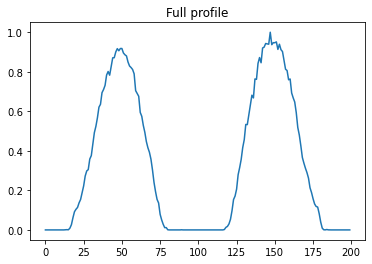

In [13]:
def get_state_from_profile(profile):
    """Returns a state description of a double splitting given a final profile.

    Args:
        profile (numpy.ndarray): array or list-like object describing a profile of a double splitting.

    Returns:
        numpy.ndarray: A numpy array of four values, [bunch_length_1, bunch_length_2, bunch_intensity_1, bunch_intensity_2]
    """   
    bunches, fwhms, intensities = isolate_bunches_from_dm_profile(profile, intensities=True, rel=True, plot_found_bunches=False)


    # Standardization/normalization
    fwhms = fwhms-np.mean(fwhms) # The FWHMs are returned normalized, but need to be centered around zero
    intensities = intensities / max(intensities) # The intensities are normalized, and centered around zero
    intensities = intensities - np.mean(intensities)
    bls_and_intensities = np.append(fwhms, intensities)
    return bls_and_intensities


profile = data_class.get_interpolated_profile(2)

state = get_state_from_profile(profile)

print(f'State description: {state}, State type: {type(state)}')
plt.figure()
plt.title('Full profile')
plt.plot(profile)


## Difference estimate (essentially optimization objective)

To further ease your implemenation of an environment, a pre-defined function to calculate a difference estimate is provided. The function takes the state computed through <code>get_state_from_profile</code> and calculates a value based on the relative bunch lengths and intensities: the larger the value the bigger the differences between the bunches.

--> In other words: **the difference estimate should be minimized**

The cell below defines the function for calculating the difference estimate from the state.

100%|██████████| 361/361 [00:01<00:00, 316.93it/s]


Text(0.5, 0, 'Phase offset [deg]')

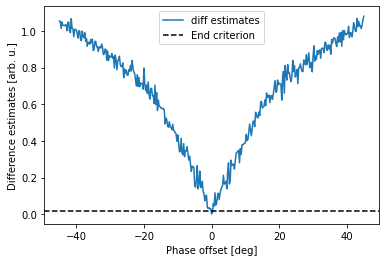

In [14]:
# Try to scan your dataset using our difference estimate and reward to make sure it is sensible

def get_diff_estimate_from_state(state):
    """
    Returns an estimate descibing the difference between the final two bunches lengths and intensities
    given the final relative bunch lengths and intensities of a double splitting (a state above).

    Args:
        state (numpy.ndarray): A numpy array of four values, [bunch_length_1, bunch_length_2, bunch_intensity_1, bunch_intensity_2]

    Returns:
        diff_estimate: A single value aiming to describe the difference between the final bunches.
    """   
    observable = state
    relative_bunch_lengths = observable[:2]
    relative_bunch_intensities = observable[2:]
    bunch_length_difference = abs(relative_bunch_lengths[0]-relative_bunch_lengths[1])
    bunch_intensity_difference = abs(relative_bunch_intensities[0]-relative_bunch_intensities[1])

    diff_estimate = bunch_intensity_difference + bunch_length_difference
    
    return diff_estimate


# Scan over our pre-simulated data range, phases [-45,45].
min_phase=-45
max_phase=45
x = np.linspace(-45,45,361)
diff_estimates = []
plt.figure()
for i in tqdm(np.linspace(min_phase,max_phase,361)):
    profile = data_class.get_interpolated_profile(i)
    state = get_state_from_profile(profile)
    diff_estimate = get_diff_estimate_from_state(state)
    diff_estimates.append(diff_estimate)
    
    
plt.plot(x,diff_estimates, label='diff estimates')
plt.axhline(0.02, color='k', linestyle='--', label='End criterion') # This is a pre-defined criterion giving a good splitting when using the diff_estimate.
plt.legend()
plt.ylabel('Difference estimates [arb. u.]')
plt.xlabel('Phase offset [deg]')

In the plot generated by the last cell, we can see that the difference estimate gives an optimum at zero phase offset, as we expect.

# Part 1 - Create your own environment

In this part of the hands-on, you will be expected to:
- implement your own environment
- train different types of RL agents in that environment

Don't worry, you will have a lot of guidance in the form of pre-defined functions and comments, but the goal is to provide you with enough knowledge to continue experimenting on your own after this session.

## Reinforcement learning recap

In the case of reinforcement learning, there are some differences in how our agents (in our cases, defined using neural networks), learn from their data. Rather than simply training on a supervised dataset with inputs and targets, the agent learns through trial and error during interaction with an *environment*. The environment supplies the agent with a state, describing the current situation of whatever problem the agent is tasked with solving. This state is given to the agent, which then makes an action affecting the environment and lands in a new state. An evaluation is run whether the action taken and the new state that we landed in was better or worse than the one before, and a *reward* is calculated. This reward describes how good the action was, and both the reward and new state are sent to the agent which then takes another action. This loop continues until the agent reaches some end criterion, which could for example be a **number of steps** or if the agent reaches a **certain state** (e.g., an optimized state). The goal of the agent during training is to maximize its total cumulative reward, which is often called the *return*. This general process is described in the agent-environment interaction loop.

<img src="./images/agent-environment.PNG" alt="rf program" width="600"/>

## Defining your environment

Before we can train any cool RL agents, we need to define the environment it will interact with. To do this, we will leverage the very widely adopted Gymnasium framework https://gymnasium.farama.org/ (a fork of the older OpenAI Gym framework).

## The Gym - implements the agent-environment interaction loop

The gym interface is simple, pythonic, and capable of representing general RL problems. It abstracts the interactions between an agent and an environment, and allows separation of the RL algorithm implementations from your custom environments. 

By defining only a few required functions, a user can create their very own environment to test their agents in, and thanks to the standardized methods other RL-libraries can often be used with these environments without any further changes required. An example library is Stable baselines3, which we will use for their implementations of different RL algorithms.

Link to SB3 documentation: https://stable-baselines3.readthedocs.io/en/master/index.html

A custom environment is created as a class that inherits the base class <code>gymnasium.Env</code> from the <code>gymnasium</code> package. An example of a skeleton environment is seen in the code cell below:

In [16]:
### EXAMPLE OF CUSTOM ENVIRONMENT SKELETON CLASS ###

import gymnasium as gym
from gymnasium import spaces

class CustomEnv(gym.Env):
  """Custom Environment that follows gym interface"""
  metadata = {'render.modes': ['human']}

  def __init__(self, arg1: any, arg2: any):
    super(CustomEnv, self).__init__()
    # Define action and observation space
    # They must be gym.spaces objects!
    
    # Example with 2D action of value [-1,1]:
    self.action_space = spaces.Box(
                                  low=np.array([-1,-1]),
                                  high=np.array([1,1]),
                                  shape=(2,), dtype=np.float32)
    # Example for using a vector of length 2 with values between [-1,1] as input:
    self.observation_space = spaces.Box(low=np.array([-1,-1]),
                                        high=np.array([1,1]),
                                        shape=(2,), dtype=np.float32)

  def step(self, action):
    """
    The step function always takes (self, action) as input, and always returns (observation, reward, terminated, truncated, info).
    Here, the different outputs are:
        observation: the latest state,
        reward: the latest returned reward (so a number),
        terminated: boolean, whether the step reached a terminal state, 
        truncated: boolean, true if the episode was truncated (without reaching a terminal state),
        info: dictionary with (optional) information.
    """
    ...
    return observation, reward, terminated, truncated, info
  def reset(self):
    ...
    return observation  # reward, done, info can't be included
  def render(self, mode='human'):
    ...
  def close (self):
    ...

In the code above you can see several functions that should be implemented if you want to use the basic gym interface. The minimum required functions are:

- **Defining your action/observation space:** this will affect the input and output size of your agents (i.e. change the neural net architectures)
- **The step() function:** Defines how your agent takes a step in your environment.
- **The reset() function:** Will be called whenever an episode ends before starting the next episode.

The render and close functions are not necessary, but can allow you to observe (or render) your environment to allow you to monitor your agents behaviour during training/testing and the close() function is to allow you to close your rendering window should this be required.

In addition to these base functions, we will create some more basic helper functions to use inside the base functions to structure our code more nicely, namely:

- **_take_action(self, action):** Actually takes the action in the environment and updates the state. - **You need to finish implementation!**
- **_get_state(self):** Get the observable given the current state we are in (evaluated from self.state) - This one is provided already with help from the <code>get_state_from_profile()</code> function above!
- **_get_reward(self):** Calculate the reward given the current state. - **You need to finish implementation!**


Once we have all of these functions defined and set up in a class we will be able to train different kinds of RL agents in the same environment without the need to change almost anything. One does however need to make sure that the algorithm you want to use matches the action/observation spaces defined (for example continuous or discrete).

## Implementing your environment

**We will begin by defining each of our important functions in a few assignments below, before finally compiling all of them together into a full environment class at the end.**

To ease the work on your side, I have left some skeleton codes for each assignment, but as you complete the earlier ones you will need to copy over your answers to the next code block in order to eventually build your complete environment.

## 1.1 The observation/action spaces

The first thing we need to define are our observation and action spaces. To conform to the gym standard, these spaces must be of a type present in <code>gym.spaces</code>.

For this intial attempt, we will go with both a continous action and observation space. In order to keep the optimization of our agents efficient, we will also be using spaces normalized to be within the range -1,1 in each dimension. For these reasons, we will be using the <code>gym.spaces.Box()</code> type spaces.

In [17]:
class YourDoubleEnv11(gym.Env):
    
    # Define your action and observation spaces. You want to take actions in one dimension, changing the h42 phase offset,
    # and want a 4D observation, consisting of your relative bunch lengths and bunch intensities. Both your observations and 
    # actions will be should be normalized to be within [-1,1] for optimisation reasons.
    
    metadata= {'render.modes': ['human']}
    
    action_space = gym.spaces.Box(
                                low = np.array([-1,]),# Fill in the _ with your lowest action. Dimensions of array correlate with dimensions of actions.
                                high = np.array([1,]),# Fill in the _ with your highest action.
                                shape=(1,),           # Fill in the _ with the dimensions of your action space.
                                dtype=np.float32)


    ### Define what the observations are to be expected
    observation_space = gym.spaces.Box(
                                low = np.array([-1,-1,-1,-1,]), # Fill in the __ with your lowest observations. This correlates to your state description!
                                high = np.array([1,1,1,1,]),# Fill in the __ with your highest observations.
                                shape=(4,),
                                dtype=np.float32)

In [18]:
from utils import test_spaces

test_environment = YourDoubleEnv11()
print(test_environment.observation_space)
print(test_environment.action_space)

test_spaces(test_environment.observation_space, test_environment.action_space)

Box(-1.0, 1.0, (4,), float32)
Box(-1.0, 1.0, (1,), float32)
Observation and action space as expected, good job!


With our observation and action spaces defined, we can try to implement our step function. In order to achieve this, we will need to also implement the helper functions, <code>_take_action()</code>, and <code>_get_state()</code> and <code>_get_reward()</code>. 

## 1.2 Define _take_action() and _get_state() functions.

In the cell below you will need to finish the implementation of the <code>_take_action()</code> function. The <code>_get_state()</code> function will also be implemented and then used in the <code>_take_action()</code> function.

In [19]:
# some self variables that you could use in the real environment class
class YourDoubleEnv12(gym.Env):
    
    # Define your action and observation spaces. You want to take actions in one dimension, changing the h42 phase offset,
    # and want a 4D observation, consisting of your relative bunch lengths and bunch intensities. Both your observations and 
    # actions will be should be normalized to be within [-1,1] for optimisation reasons.
    
    metadata= {'render.modes': ['human']}
    
    action_space = gym.spaces.Box(
                                low = np.array([-1,]),#__, # Fill in the __ with your action settings.
                                high = np.array([1,]),#__,
                                shape=(1,),
                                dtype=np.float32)


    ### Define what the observations are to be expected
    observation_space = gym.spaces.Box(
                                low = np.array([-1,-1,-1,-1]), # Fill in the __ with your observation settings.
                                high = np.array([1,1,1,1]),
                                shape=(4,),
                                dtype=np.float32)
    
    ### Stop criteria (constituting "good" splittings with provided difference estimate).
    BUNCH_LENGTH_INT_CRITERIA = 0.02 # Empirically evaluated diff_estimate that constitutes a "good" bunch splitting. Lower means longer training time, but smaller spread in bunch lengths/intensities.
    

    
    

    def __init__(self,
                max_steps = 100,
                max_step_size = 20,
                min_setting = -45,
                max_setting = 45,):
        
        ### Assign hyperparameter settings to attributes
        self.max_steps = max_steps
        self.max_step_size = max_step_size
        self.min_setting = min_setting
        self.max_setting = max_setting
        
        ### Status of the iterations
        # Steps, initializing lists to store actions/states/rewards...
        self.counter = 0
        self.phase_correction = 0
        self.phase_set = 0

        # Initialize lists for tracking episodes
        self.curr_episode = -1
        self.action_episode_memory = []
        self.diff_estimate_memory = []
        self.state_memory = []
        self.phase_set_memory = []
        self.reward_memory = []
        self.is_finalized = False
    

    def _take_action(self, action):
        """
        Actual action funtion.

        Action from model is scaled to be between [-1,1] for better optimization performance. 
        Converted back to phase setting in degrees using self.max_step_size.
        
        Args:
            action (ndarray): n-dimensional action. Datatype, dimension, and value ranges defined in self.action_space.
        """
        #######################################################################################################
        # Implement the code below!!
        #######################################################################################################

        converted_action = action*self.max_step_size # Convert your action from your normalized range [-1,1] back into degrees using self.max_step_size. HINT: action*self.max_step_size = what?
        self.phase_correction += converted_action # Phase correction tracks previous actions taken to get the cumulative change from start.

        # Phase offset as action, add offset to current phase_set to get next setting. This is what defines which simulated datapoint to collect in your _get_state function!!!
        self.phase_set += converted_action

        # Update the self.state parameter with the new state. The preprovided self._get_state() will provide you with a state based on the current self.phase_set attribute value.
        # The state will consist of a vector of 4 values: [bunch_length_1, bunch_length_2, bunch_intensity_1, bunch_intensity_2].
        self.state = self._get_state()


        ################################################################################################################################################################
        # Implement the code above!!
        ################################################################################################################################################################  
        curr_state = self.state.copy()
        curr_phase_set = np.copy(self.phase_set)
        self.action_episode_memory[self.curr_episode].append(action)
        self.state_memory[self.curr_episode].append(curr_state)
        self.phase_set_memory[self.curr_episode].append(curr_phase_set)
        
        self.counter += 1

     
    
    def _get_state(self):
        '''
        Get the observable for a given phase_set. This function is provided completed to help you collect datapoints from the pre-simulated dataset.
        The data_class class is written to provide datapoints from a quadsplit dataset, but by always providing h84=0 we only vary the first phase
        offset.

        Comment: The edge cases of trying to move to datapoints outside the simulated dataset needs to be handled.
        Currently it is simply checked whether the phase setting is above the max setting or below the min setting,
        and if so a pre-defined dummy observation is presented. The important factor to consider is to make sure that
        all edge cases are covered by some dummy state, and that the dummy states are unique (so the model can learn
        what steps to take to get back in the right search area). It is also highly advised to give an additional penalty
        in the reward if the agent steps outside our region of simulated data.
        '''
        
        ### Check whether we are within simulated settings
        if (self.phase_set<self.min_setting):
            state = np.array([0.5, -0.5, 0.5, -0.5])
        elif (self.phase_set>self.max_setting):
            state = np.array([-0.5, 0.5, -0.5, 0.5])
        else:
            
            ################################################################################################################################################################
            # Implement the code below!!
            #########################################################################################################################
            
            # You want to collect a profile corresponding to the current self.phase_set, and then calculate the state description.
            profile = data_class.get_interpolated_profile(self.phase_set) # Second phase does not affect the first. Since we only care about h42, no need to assign h84 offfset.
            state = get_state_from_profile(profile)
            
            # Hint: Remember the help functions for getting a profile from the dataset and turning a profile into a state.

            ################################################################################################################################################################
            # Implement the code above!!
            ################################################################################################################################################################

        return state.astype(np.float32)

    def reset(self):
        """
        Reset to a random state to start over a training episode.
        This function will be called everytime an episode is started
        to provide an initial state.
        
        Returns:
            state: The inital state of the environment. Should match the shape defined in observation_space.
        """
        # Resetting to start a new episode
        self.curr_episode += 1
        self.counter = 0
        self.is_finalized = False # This tracks wether an episode is complete or not.
        
        #print(f'Resetting for episode {self.curr_episode}')

        # Initializing episode lists to track data for individual episodes. Some used for rendering.
        self.action_episode_memory.append([])
        self.state_memory.append([])
        self.phase_set_memory.append([])
        self.reward_memory.append([])
        self.diff_estimate_memory.append([])
        
        ################################################################################################################################################################
        # Implement the code below!!
        ################################################################################################################################################################
        
        # Getting initial state
        
        # Initialize random starting phase_set within [self.min_setting, self.max_setting], for example using random.uniform(min,max)
        self.phase_set = random.uniform(self.min_setting,
                                            self.max_setting)
        
        self.initial_offset = np.copy(self.phase_set)
        self.phase_correction = 0
                                        
        self.state = self._get_state() # call _get_state to get the initial state from the starting phase_set.
        state = self.state
        
        ################################################################################################################################################################
        # Implement the code above!!
        ################################################################################################################################################################

        
        return state.astype(np.float32)

Let's now test your <code>_take_action</code> method below...

The environment above will be initialized, reset to a starting setting using the provided reset() function, and then checked to make sure that the <code>_take_action</code> function updates the <code>self.phase_set</code> attribute.

Two plots of the initial and final states will also be produced, check that these are different to make sure you also actually update the <code>self.state</code> attribute!

Initial phase_setting: 10.323829294933184
Final phase_setting after taking 10 degree action: 20.323829294933184
 _take_action updated self.phase_set correctly. Good job!


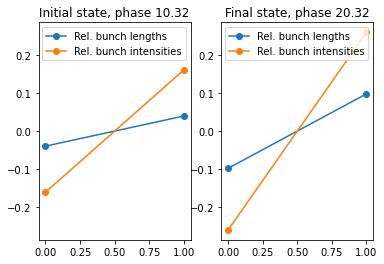

In [20]:
test_environment = YourDoubleEnv12()
test_environment.reset() # Reset env to a random starting phase_setting

init_phase = test_environment.phase_set
init_state = test_environment.state

print(f'Initial phase_setting: {init_phase}')

phase_action = 10
normalized_action = phase_action/test_environment.max_step_size # Convert a 10 degree step into normalized action.
test_environment._take_action(normalized_action)

final_phase = test_environment.phase_set
final_state = test_environment.state

print(f'Final phase_setting after taking {phase_action} degree action: {test_environment.phase_set}')

assert test_environment.phase_set == init_phase+phase_action
print(' _take_action updated self.phase_set correctly. Good job!')

plt.figure()
ax1 = plt.subplot(121)
plt.title(f'Initial state, phase {init_phase:.2f}')
plt.plot(init_state[:2], 'o-', label = 'Rel. bunch lengths')
plt.plot(init_state[2:], 'o-', label = 'Rel. bunch intensities')
plt.legend()
ax2 = plt.subplot(122, sharey=ax1)
plt.title(f'Final state, phase {final_phase:.2f}')
plt.plot(final_state[:2], 'o-', label = 'Rel. bunch lengths')
plt.plot(final_state[2:], 'o-', label = 'Rel. bunch intensities')
plt.legend()


## 1.3 Define _get_reward() function.

The <code>_get_reward()</code> function will be called after we have taken an action, to calculate a reward based on the state we ended up in. This is the second function we will need to assemble our <code>step()</code> method.

In [21]:
# some self variables that you could use in the real environment class
class YourDoubleEnv13(gym.Env):
    
    # Define your action and observation spaces. You want to take actions in one dimension, changing the h42 phase offset,
    # and want a 4D observation, consisting of your relative bunch lengths and bunch intensities. Both your observations and 
    # actions will be should be normalized to be within [-1,1] for optimisation reasons.
    
    metadata= {'render.modes': ['human']}
    
    action_space = gym.spaces.Box(
                                low = np.array([-1,]),#__, # Fill in the __ with your action settings.
                                high = np.array([1,]),#__,
                                shape=(1,),
                                dtype=np.float32)


    ### Define what the observations are to be expected
    observation_space = gym.spaces.Box(
                                low = np.array([-1,-1,-1,-1]), # Fill in the __ with your observation settings.
                                high = np.array([1,1,1,1]),
                                shape=(4,),
                                dtype=np.float32)
    
    ### Stop criteria (constituting "good" splittings with provided difference estimate).
    BUNCH_LENGTH_INT_CRITERIA = 0.02 # Empirically evaluated diff_estimate that constitutes a "good" bunch splitting. Lower means longer training time, but smaller spread in bunch lengths/intensities.
    

    
    

    def __init__(self,
                max_steps = 100,
                max_step_size = 20,
                min_setting = -45,
                max_setting = 45,):
        
        ### Assign hyperparameter settings to attributes
        self.max_steps = max_steps
        self.max_step_size = max_step_size
        self.min_setting = min_setting
        self.max_setting = max_setting
        
        ### Status of the iterations
        # Steps, initializing lists to store actions/states/rewards...
        self.counter = 0
        self.phase_correction = 0
        self.phase_set = 0

        # Initialize lists for tracking episodes
        self.curr_episode = -1
        self.action_episode_memory = []
        self.diff_estimate_memory = []
        self.state_memory = []
        self.phase_set_memory = []
        self.reward_memory = []
        self.is_finalized = False
    

    def _take_action(self, action):
        """
        Actual action funtion.

        Action from model is scaled to be between [-1,1] for better optimization performance. 
        Converted back to phase setting in degrees using self.max_step_size.
        
        Args:
            action (ndarray): n-dimensional action. Datatype, dimension, and value ranges defined in self.action_space.
        """
        ################################################################################################################################################################
        # Implement the code below!!
        ################################################################################################################################################################

        converted_action = action*self.max_step_size # Convert your action from your normalized range [-1,1] back into degrees using self.max_step_size. HINT: action*self.max_step_size = what?
        self.phase_correction += converted_action # Phase correction tracks previous actions taken to get the cumulative change from start.

        # Phase offset as action, add offset to current phase_set to get next setting. This is what defines which simulated datapoint to collect in your _get_state function!!!
        self.phase_set += converted_action

        # Update the self.state parameter with the new state. The preprovided self._get_state() will provide you with a state based on the current self.phase_set attribute value.
        # The state will consist of a vector of 4 values: [bunch_length_1, bunch_length_2, bunch_intensity_1, bunch_intensity_2].
        self.state = self._get_state()


        ################################################################################################################################################################
        # Implement the code above!!
        ################################################################################################################################################################  
        curr_state = self.state.copy()
        curr_phase_set = np.copy(self.phase_set)
        self.action_episode_memory[self.curr_episode].append(action)
        self.state_memory[self.curr_episode].append(curr_state)
        self.phase_set_memory[self.curr_episode].append(curr_phase_set)
        
        self.counter += 1

     
    
    def _get_state(self):
        '''
        Get the observable for a given phase_set. This function is provided completed to help you collect datapoints from the pre-simulated dataset.
        The data_class class is written to provide datapoints from a quadsplit dataset, but by always providing h84=0 we only vary the first phase
        offset.

        Comment: The edge cases of trying to move to datapoints outside the simulated dataset needs to be handled.
        Currently it is simply checked whether the phase setting is above the max setting or below the min setting,
        and if so a pre-defined dummy observation is presented. The important factor to consider is to make sure that
        all edge cases are covered by some dummy state, and that the dummy states are unique (so the model can learn
        what steps to take to get back in the right search area). It is also highly advised to give an additional penalty
        in the reward if the agent steps outside our region of simulated data.
        '''
        
        ### Check whether we are within simulated settings
        if (self.phase_set<self.min_setting):
            state = np.array([0.5, -0.5, 0.5, -0.5])
        elif (self.phase_set>self.max_setting):
            state = np.array([-0.5, 0.5, -0.5, 0.5])
        else:
            
            ################################################################################################################################################################
            # Implement the code below!!
            #########################################################################################################################
            
            # You want to collect a profile corresponding to the current self.phase_set, and then calculate the state description.
            profile = data_class.get_interpolated_profile(self.phase_set) # Second phase does not affect the first. Since we only care about h42, no need to assign h84 offfset.
            state = get_state_from_profile(profile)
            
            # Hint: Remember the help functions for getting a profile from the dataset and turning a profile into a state.

            ################################################################################################################################################################
            # Implement the code above!!
            ################################################################################################################################################################

        return state.astype(np.float32)
    
    def _get_reward(self):
        """ Evaluating the reward from the observable/state. 
            The example reward 'simple_profile' is provided, and is based on the final profile
            after the splitting. This is using more information than just the state provided
            to the agent.

            Feel free to experiment and design your own reward as well! 

        Returns:
            float: The reward based on the current state. 
        """ 
        
        # The shape of your observable should match your optimization_space. For this excercise, it is expected
        # that you use an observation space of a vector with four values
        observable = self.state

        diff_estimate = get_diff_estimate_from_state(observable)
        self.diff_estimate = diff_estimate

        ################################################################################################################################################################
        # Implement the code below!!
        ################################################################################################################################################################
        """ 
         Define your own reward here. The diff_estimate provided above is provided 
         as a simple way to define the difference between your bunches length/intensity 
         after the splitting. You want this to be as small as possible, so a better reward
         should be given for a smaller diff_estimate. There is already a pre-defined
         criterion for the diff_estimate to be considered a "good" splitting provided in
         the BUNCH_LENGTH_INT_CRITERIA attribute. 
         """

        reward = -diff_estimate #______ # Define your own reward here!! 

        ################################################################################################################################################################
        # Implement the code above!!
        ################################################################################################################################################################
        
        ### Tracking of diff_estimate. Lets you use my render() function to observe your agent.
        curr_diff_estimate = self.diff_estimate.copy()
        self.diff_estimate_memory[self.curr_episode].append(curr_diff_estimate)
        self.reward_memory[self.curr_episode].append(reward)
            
        return reward
    
    def reset(self):
        """
        Reset to a random state to start over a training episode.
        This function will be called everytime an episode is started
        to provide an initial state.
        
        Returns:
            state: The inital state of the environment. Should match the shape defined in observation_space.
        """
        # Resetting to start a new episode
        self.curr_episode += 1
        self.counter = 0
        self.is_finalized = False # This tracks wether an episode is complete or not.
        
        #print(f'Resetting for episode {self.curr_episode}')

        # Initializing episode lists to track data for individual episodes. Some used for rendering.
        self.action_episode_memory.append([])
        self.state_memory.append([])
        self.phase_set_memory.append([])
        self.reward_memory.append([])
        self.diff_estimate_memory.append([])
        
        
        # Getting initial state
        
        # Initialize random starting phase_set within [self.min_setting, self.max_setting], for example using random.uniform(min,max)
        self.phase_set = random.uniform(self.min_setting,
                                            self.max_setting)
        
        self.initial_offset = np.copy(self.phase_set)
        self.phase_correction = 0
                                        
        self.state = self._get_state() # call _get_state to get the initial state from the starting phase_set.
        state = self.state
        
        return state.astype(np.float32)

Testing the <code>_get_reward</code> function...

<IPython.core.display.Javascript object>


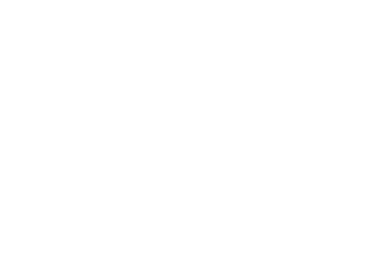

In [22]:
test_environment = YourDoubleEnv13()
%matplotlib notebook
from utils import test_reward
# Set the environment to different states in our observation space, and check the value of the reward.
# We will also plot our difference estimate, to see that our rewards are reasonable in relation to our
# bunch characteristics.

test_reward(test_environment)




Assuming you are happy with your reward shape, you are now ready to assemble the main function of your environment: the <code>step()</code> function.

## 1.4 Define the step() function

We will define the <code>step()</code> function with the helper functions defined in 1.2-1.3. Both the input and the output of the function are pre-defined according to the <code>gym</code> standard.

- **Input**: self (the class object and its attributes), action (the action you want to take in the environment).
- **Output**: 4-tuple of state, reward, is_finalized, info
    - **state**: the end state after taking a step
    - **reward**: the reward given after taking the step and landning in state
    - **is_finalized**: boolean that is true if the state is terminal, false otherwise.
    - **info**: dictionary where it is possible to return any extra information you may be interested in (e.g. for debugging, plotting...)
    
Below you will find a class where a skeleton for the <code>step()</code> function is given. It uses the functions and spaces from excercises 1.1-1.3, so copy them down into their corresponding locations.
    
To help you in the implementation, the following pseudocode is provided:

```python
def step(self, action):
    
1. Take action *action* 
2. Get the reward given by following *state*.
3. Check exit criterions
    
    3.1 Is the self.diff_estimate < BUNCH_LENGTH_INT_CRITERIA?
        Yes: Episode is_terminated = True, success = True.
        No: pass
    
    3.2 Are our number_of_steps > max_steps?
        Yes: Episode is_truncated = True, success = False.
        No: pass

return state, reward, is_terminated, is_truncated, info
```

In [67]:
# some self variables that you could use in the real environment class
class YourDoubleEnv(gym.Env):
    
    # Define your action and observation spaces. You want to take actions in one dimension, changing the h42 phase offset,
    # and want a 4D observation, consisting of your relative bunch lengths and bunch intensities. Both your observations and 
    # actions will be should be normalized to be within [-1,1] for optimisation reasons.
    
    metadata= {'render.modes': ['human']}
    
    action_space = gym.spaces.Box(
                                low = np.array([-1,]),#__, # Fill in the __ with your action settings.
                                high = np.array([1,]),#__,
                                shape=(1,),
                                dtype=np.float32)


    ### Define what the observations are to be expected
    observation_space = gym.spaces.Box(
                                low = np.array([-1,-1,-1,-1]), # Fill in the __ with your observation settings.
                                high = np.array([1,1,1,1]),
                                shape=(4,),
                                dtype=np.float32)
    
    ### Stop criteria (constituting "good" splittings with provided difference estimate).
    BUNCH_LENGTH_INT_CRITERIA = 0.02 # Empirically evaluated diff_estimate that constitutes a "good" bunch splitting. Lower means longer training time, but smaller spread in bunch lengths/intensities.
    

    
    

    def __init__(self,
                max_steps = 100,
                max_step_size = 20,
                min_setting = -45,
                max_setting = 45,):
        
        ### Assign hyperparameter settings to attributes
        self.max_steps = max_steps
        self.max_step_size = max_step_size
        self.min_setting = min_setting
        self.max_setting = max_setting
        
        ### Status of the iterations
        # Steps, initializing lists to store actions/states/rewards...
        
        self.counter = 0 # Counts the number of steps taken in the environment!
        self.phase_correction = 0

        # Initialize lists for tracking episodes
        self.curr_episode = -1
        self.action_episode_memory = []
        self.diff_estimate_memory = []
        self.state_memory = []
        self.phase_set_memory = []
        self.reward_memory = []
        self.is_terminated = False
        self.is_truncated = False
        
        self.render_figure = None
    
    def step(self, action):
        """
        One step/action in the environment, returning the observable
        and reward. 

        Stopping conditions: max_steps reached, or splitting good enough.
        """
        success = False    
        ################################################################################################################################################################
        # Implement the code below!!
        ################################################################################################################################################################
        
        # Hint: Number of steps taken in environment is tracked in self.counter
        
        
        self._take_action(action) # Actually take action: Define your _take_action function below!! 
        reward = self._get_reward() # Get your reward: Define your _get_reward function below!! Returns a reward value.
        
        state = self.state
        ### Check exit criteria: Achieved good enough state, or taken too many steps.
        ### BUNCH_LENGHT_INT_CRITERIA based on the given diff_estimate value.
        
        if abs(self.diff_estimate) < self.BUNCH_LENGTH_INT_CRITERIA: # Check if the diff_estimate is below criterion. If so, episode finalized and a success!
            self.is_terminated = True 
            success = True
        # print(self.counter)    
        if self.counter >= self.max_steps: # Check if you have exceeded the maximum step limit. If so, episode truncated but not a success...
            self.is_truncated = True

        # Here you can add any extra info you would like to be returned on each step, e.g. episode steps, rewards, actions etc.
        info = {'success': success, 'steps': self.counter, 'profile': self.profile} 
        
        ################################################################################################################################################################
        # Implement the code above!!
        ################################################################################################################################################################
        
        
        return state, reward.astype(np.float64), self.is_terminated, self.is_truncated, info # Standardized output according to gym framework.

    def _take_action(self, action):
        """
        Actual action funtion.

        Action from model is scaled to be between [-1,1] for better optimization performance. 
        Converted back to phase setting in degrees using self.max_step_size.
        
        Args:
            action (ndarray): n-dimensional action. Datatype, dimension, and value ranges defined in self.action_space.
        """
        ################################################################################################################################################################
        # Implement the code below!!
        ################################################################################################################################################################

        converted_action = action*self.max_step_size # Convert your action from your normalized range [-1,1] back into degrees using self.max_step_size. HINT: action*self.max_step_size = what?
        self.phase_correction += converted_action # Phase correction tracks previous actions taken to get the cumulative change from start.

        # Phase offset as action, add offset to current phase_set to get next setting. This is what defines which simulated datapoint to collect in your _get_state function!!!
        self.phase_set += converted_action

        # Update the self.state parameter with the new state. The preprovided self._get_state() will provide you with a state based on the current self.phase_set attribute value.
        # The state will consist of a vector of 4 values: [bunch_length_1, bunch_length_2, bunch_intensity_1, bunch_intensity_2].
        self.state = self._get_state()


        ################################################################################################################################################################
        # Implement the code above!!
        ################################################################################################################################################################  
        curr_state = np.copy(self.state)
        curr_phase_set = np.copy(self.phase_set)
        self.action_episode_memory.append(action)
        self.state_memory.append(curr_state)
        self.phase_set_memory.append(curr_phase_set)
        
        self.counter += 1

     
    
    def _get_state(self):
        '''
        Get the observable for a given phase_set. This function is provided completed to help you collect datapoints from the pre-simulated dataset.
        The data_class class is written to provide datapoints from a quadsplit dataset, but by always providing h84=0 we only vary the first phase
        offset.

        Comment: The edge cases of trying to move to datapoints outside the simulated dataset needs to be handled.
        Currently it is simply checked whether the phase setting is above the max setting or below the min setting,
        and if so a pre-defined dummy observation is presented. The important factor to consider is to make sure that
        all edge cases are covered by some dummy state, and that the dummy states are unique (so the model can learn
        what steps to take to get back in the right search area). It is also highly advised to give an additional penalty
        in the reward if the agent steps outside our region of simulated data.
        '''
        
        ### Check whether we are within simulated settings
        if (self.phase_set<self.min_setting):
            state = np.array([0.5, -0.5, 0.5, -0.5])
        elif (self.phase_set>self.max_setting):
            state = np.array([-0.5, 0.5, -0.5, 0.5])
        else:
            
            ################################################################################################################################################################
            # Implement the code below!!
            #########################################################################################################################
            
            # Collecting the simulated datapoint, calculating state description
            profile = data_class.get_interpolated_profile(self.phase_set) # Second phase does not affect the first. Since we only care about h42, no need to assign h84 offfset.
            state = get_state_from_profile(profile)
            
            ################################################################################################################################################################
            # Implement the code above!!
            ################################################################################################################################################################
        
            self.profile = profile # Add a tracking of the profile for plotting purposes!
        return state.astype(np.float32)
    
    def _get_reward(self):
        """ Evaluating the reward from the observable/state. 
            The example reward 'simple_profile' is provided, and is based on the final profile
            after the splitting. This is using more information than just the state provided
            to the agent.

            Feel free to experiment and design your own reward as well! 

        Returns:
            float: The reward based on the current state. 
        """ 
        
        
        
        # The shape of your observable should match your optimization_space. For this excercise, it is expected
        # that you use an observation space of a vector with four values
        observable = self.state

        diff_estimate = get_diff_estimate_from_state(observable)
        self.diff_estimate = diff_estimate

        ################################################################################################################################################################
        # Implement the code below!!
        ################################################################################################################################################################
        """ 
         Define your own reward here. The diff_estimate provided above is provided 
         as a simple way to define the difference between your bunches length/intensity 
         after the splitting. You want this to be as small as possible, so a better reward
         should be given for a smaller diff_estimate. There is already a pre-defined
         criterion for the diff_estimate to be considered a "good" splitting provided in
         the BUNCH_LENGTH_INT_CRITERIA attribute. 
         """

        reward = -diff_estimate #______ # Define your own reward here!! 

        ################################################################################################################################################################
        # Implement the code above!!
        ################################################################################################################################################################
        
        ### Tracking of diff_estimate. Lets you use my render() function to observe your agent.
        curr_diff_estimate = self.diff_estimate.copy()
        self.diff_estimate_memory.append(curr_diff_estimate)
        self.reward_memory.append(reward)
            
        return reward
       
    def reset(self, seed: int | None = None) -> tuple:
        """
        Reset to a random state to start over a training episode.
        This function will be called everytime an episode is started
        to provide an initial state.
        
        Returns:
            state: The inital state of the environment. Should match the shape defined in observation_space.
        """
        super().reset(seed=seed)  # Set the seed.
        
        # Resetting to start a new episode
        self.curr_episode += 1
        self.counter = 0
        self.is_terminated = False # This tracks wether an episode is complete or not.
        self.is_truncated = False # This tracks wether an episode is complete or not.
        
        #print(f'Resetting for episode {self.curr_episode}')

        # Initializing episode lists to track data for individual episodes. Some used for rendering.
        self.action_episode_memory = []
        self.state_memory= []
        self.phase_set_memory= []
        self.reward_memory= []
        self.diff_estimate_memory= []
        
        ################################################################################################################################################################
        # Implement the code below!!
        ################################################################################################################################################################
        
        # Getting initial state
        
        # Initialize random starting phase_set within [self.min_setting, self.max_setting], for example using random.uniform(min,max)
        self.phase_set = random.uniform(self.min_setting,
                                            self.max_setting)
        
        self.initial_offset = np.copy(self.phase_set)
        self.phase_correction = 0
                                        
        self.state = self._get_state() # call _get_state to get the initial state from the starting phase_set.
        state = self.state
        
        ################################################################################################################################################################
        # Implement the code above!!
        ################################################################################################################################################################
 
        ### Some tracking of state, phase, reward, diff_estimate. Lets you use my render() function to observe your agent.
        self.state_memory.append(state)
        self.phase_set_memory.append(self.phase_set)
        reward = self._get_reward()
        self.reward_memory.append(reward)
        
        _, _, _, _, info = self.step(0)  # Get the info to return
        
        return state.astype(np.float32), info

        
    def render(self, mode='human'):
        
        """
        Rendering function meant to provide a human-readable output. Base function in gym
        environments to override. I provide a simple version that should let you observe 
        your trained agent during evaluation.
        """
        if self.render_figure is None:
            self.render_figure = plt.figure('Agent')
        plt.figure(self.render_figure)
        plt.clf()
        plt.subplot(131)
        plt.suptitle(f'Episode {self.curr_episode}')
        plt.title('Current profile')
        plt.plot(self.profile,'b')
        plt.subplot(132)
        plt.title('Difference estimate')
        plt.plot(self.diff_estimate_memory, 'o-')
        plt.axhline(y=self.BUNCH_LENGTH_INT_CRITERIA, color='k', linestyle='--')
        plt.subplot(133)
        plt.title('h42 phase offset')
        plt.plot(np.asarray(self.phase_set_memory, dtype=object), 'go-')
        plt.axhline(y=0, color='k', linestyle='--')
        plt.ylim((-30,30))
        plt.show()
        
        #plot_finish(fig=fig, axes=axes, xlabel='Setting', ylabel='Observable')
        plt.pause(0.2)
        

**With the environment above completed and implemented, our environment is complete!**

As a final test, we can use an **environment checker** provided by stable-baselines3 to check whether our environment truly follows the standards of gym and SB3.


In [68]:
from stable_baselines3.common.env_checker import check_env
env = YourDoubleEnv()

result = check_env(env)

if result==None:
    print(f'Check env succesful!')
else:
    print(f"Check env unsuccessful, \n Result: {result}")

Check env succesful!


# Part 2: Training RL-agents in your environment

Now that your environment is ready, it is time to train some agents! We will focus on the deep RL methods implemented in Stable Baselines 3, as they are generally compatible with a generic gym evnironment and very powerful for solving problems without the need of modeling (the algorithms we will use today are all *model-free*).

**We will start with one of the most prominent actor-critic methods: Soft Actor Critic (SAC).**


## 2.1 Soft Actor Critic

**Soft Actor critic is a model-free, off-policy, actor-critic algorithm that optimizes a stochastic policy**. In essence, this means it is easy to apply to new problems, and learns simply through it's experiences with no need for a previous policy or model to be declared.

The algorithm is also known for being **relatively stable**, with little need for hyperparameter tuning (an otherwise common issue in RL). Due to these reasons, it has become a popular algorithms for a variety of tasks.


- You can read a summarized introduction to the algorithm at OpenAI SpinningUp: https://spinningup.openai.com/en/latest/algorithms/sac.html#soft-actor-critic,

- or see the original paper: https://arxiv.org/pdf/1801.01290.pdf,

- and the Stable Baselines3 documentation: https://stable-baselines3.readthedocs.io/en/master/modules/sac.html .

In [77]:
# Train a model
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold


# Separate evaluation env
eval_env = YourDoubleEnv()

# Use deterministic actions for evaluation
eval_callback = EvalCallback(eval_env,  best_model_save_path='./RL_logs/SAC', # Define a callback to evaluate our model 
    log_path='./RL_logs/', eval_freq=200,                                     # periodically. Also saves the best evaluated
    deterministic=True, render=False)                                         # model to ./RL_logs/SAC/best_model.zip.


env = YourDoubleEnv()

seed = 7
np.random.seed(seed)
env.reset(seed=seed)
log_dir = './'


ent_coef = 1/5#'auto' # Hyperparameter of SAC, with 'auto' it is also learned during training.

# Define your model
sac_model = SAC("MlpPolicy", env, verbose=1, ent_coef=ent_coef, learning_starts=100, tensorboard_log="./hands-on_rl_tensorboard")
print("Starting training...")
sac_model.learn(total_timesteps=1000, callback=eval_callback, log_interval=1, tb_log_name="hands_on_rl-SAC")
sac_model.save('./saved_models/SAC_RL_agent') # Save our final model
print("Completed training")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Starting training...
Logging to ./hands-on_rl_tensorboard/hands_on_rl-SAC_6
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 99       |
|    ep_rew_mean     | -143     |
| time/              |          |
|    episodes        | 1        |
|    fps             | 174      |
|    time_elapsed    | 0        |
|    total_timesteps | 99       |
---------------------------------


KeyboardInterrupt: 

# Monitoring through tensorboard (not working on SWAN)

**Monitoring training through Tensorboard**

If you want to track the training above and also see the loss curves of your model, you can use Tensorboard. In a normal jupyter notebook you should be able to run tensorboard directly using 

<code>
    %load_ext tensorboard
    %tensorboard --logdir ./RL_logs
</code>

You may need to run the command <code>%reload_ext tensorboard</code> occasionally to update the tensorboard data.

**I recommend you try this after training to be able to see interesting metrics of your agent and how they evolve with training!**



In the tensorboard graphs, you can see how your agent evolves over time. If you look under the tab "rollout", you will be able to see two graphs: **ep_len_mean** and **ep_rew_mean**, who stand for mean episode length and mean episode reward, respectively. Here you will be able to track how your agent is performing on average during training, with the timesteps on the x-axis. Of course you want the mean reward to be as large as possible, and the episode length to be as small as possible.



You can try and see if you understand the other tensorboard graphs on your own, otherwise feel free to ask.

In [37]:
%load_ext tensorboard

In [40]:
#%reload_ext tensorboard
%tensorboard --logdir ./hands-on_rl_tensorboard

Reusing TensorBoard on port 6006 (pid 880), started 0:00:11 ago. (Use '!kill 880' to kill it.)

In [42]:
### Loading 1000 timesteps SAC model

sac_model = SAC.load('./saved_models/SAC_RL_agent')

## Test your trained agent

Now you should have a simple agent trained, after taking 1000 steps in the environment. Now let's test it!

In [71]:
def test_trained_agent(environment, agent, test_episodes_to_run = 10, render_opt=False):
    obs, _ = environment.reset()
    
    performance = [0,0]
    steps_per_episode = []
    predicted_phase_error_when_done = []
    done=False
    start_diff_estimates = []
    end_diff_estimates = []
    initial_profiles = []
    final_profiles = []
    counter = 0
    episode = 0

    plt.figure('Agent')
    for episode in range(test_episodes_to_run):
        done=False
        first_step = True
        #print(obs)
        while not done:
            action, _states = agent.predict(obs, deterministic=True)
            #print(f' action {action}')
            obs, rewards, terminated, truncated, info = test_env.step(action)
            done = terminated or truncated
            if render_opt:
                test_env.render() # Use if you want to observe the agent
                if done:
                    time.sleep(1) # allow some time to see complete trajectory before starting next episode.
            if done:

                print(f"Took {info['steps']} steps before terminating test")
                steps_per_episode.append(info['steps'])
                #print(f"Info {info}")
                
                if info['success'] == True:
                    performance[0] += 1
                else:
                    performance[1] += 1

                if counter < 5:
                    final_profiles.append(info['profile'])
                counter += 1
                obs, _ = test_env.reset()
    print(f"Succesful optimizations: {performance[0]}")
    print(f"Unsuccesful optimizations: {performance[1]}")
    print(f"Accuracy: {performance[0]/(performance[0]+performance[1])*100}%")
    print(f"Mean episode length: {np.sum(steps_per_episode)/len(steps_per_episode)}")
    print(f"Max episode length: {np.max(steps_per_episode)}, Min episode length: {np.min(steps_per_episode)}")


<IPython.core.display.Javascript object>


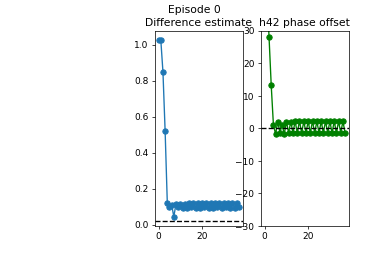

Took 3 steps before terminating test
Took 100 steps before terminating test
Took 100 steps before terminating test
Took 3 steps before terminating test
Took 11 steps before terminating test
Took 100 steps before terminating test
Took 3 steps before terminating test
Took 100 steps before terminating test
Took 100 steps before terminating test
Took 100 steps before terminating test
Succesful optimizations: 4
Unsuccesful optimizations: 6
Accuracy: 40.0%
Mean episode length: 62.0
Max episode length: 100, Min episode length: 3


In [73]:
%matplotlib qt
# Reset environment
# Create new test env
test_env = YourDoubleEnv()


test_trained_agent(test_env, sac_model, render_opt = False) # If you want to test for more episodes, you set render_opt=False
                                                           # and add an input test_episodes_to_run = 1000.

In [78]:
# Alternatively to running with the sac_model stored in memory, we can load our best model 
# evaluated during testing.

sac_model_loaded_best = SAC.load('./RL_logs/SAC/best_model')
test_env = YourDoubleEnv()
test_trained_agent(test_env, sac_model_loaded_best, render_opt = True)

KeyboardInterrupt: 

## How did your agent work?

Did it manage to solve the problem during testing? What if you train the agent for a longer duration? Feel free to experiment with the hyperparameters of your training until you get an SAC-agent you are happy with.

- How fast is your best agent at optimizing the splitting?
- Think about what limitations there are on the optimization efficiency. What is needed to allow the agent a (theoretical) one-step optimization?

## Compare with pre-trained agent

As an example of a well trained agent, you can load the super_agent below and test it in an environment, to see the efficiency that you can get out of an SAC agent with this problem.



In [79]:
super_model = SAC.load('./RL_logs/SAC/Super_lims_45/best_model')
test_env = YourDoubleEnv(max_step_size=45)
test_trained_agent(test_env, super_model, render_opt = True)

ModuleNotFoundError: No module named 'gym'

## Versatility of your Gym environment: Training other agents (other algorithms)

Now, to illustrate the utility of the gym framework, we will also train another RL agent using a different algorithm: TD3.

## 2.2 Twin Delayed Deep Deterministic Policy Gradient (TD3)

Similar to SAC (and developed around the same time) TD3 is also a model-free off-policy RL algorithm. It improves upon the older DDPG agent and is based on so-called policy gradient methods. In contrast with SAC, TD3 always produces a deterministic policy after training.

Spinning Up: https://spinningup.openai.com/en/latest/algorithms/td3.html

Stable Baselines3 docs: https://stable-baselines3.readthedocs.io/en/master/modules/td3.html

In [151]:
from stable_baselines3 import TD3
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise


# Separate evaluation env
eval_env = YourDoubleEnv()

# Use deterministic actions for evaluation
eval_callback = EvalCallback(eval_env,  best_model_save_path='./RL_logs/TD3',
    log_path='./RL_logs/', eval_freq=100,
    deterministic=True, render=False)


env = YourDoubleEnv()

# The noise objects for TD3. Injects noise in the actions to encourage exploration.
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

seed = 7
np.random.seed(seed)
env.seed(seed)
log_dir = './'



# Define your model
td3_model = TD3("MlpPolicy", env, action_noise=action_noise, verbose=1, tensorboard_log="./hands-on_rl_tensorboard")
print("Starting training...")
td3_model.learn(total_timesteps=1000, callback=eval_callback, log_interval=1, tb_log_name="hands_on_rl_TD3")
td3_model.save('./saved_models/RL_agent_TD3')
print("Completed training")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Starting training...
Logging to ./hands-on_rl_tensorboard\hands_on_rl_TD3_5
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7        |
|    ep_rew_mean     | -2.92    |
| time/              |          |
|    episodes        | 1        |
|    fps             | 304      |
|    time_elapsed    | 0        |
|    total_timesteps | 7        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7        |
|    ep_rew_mean     | -3.42    |
| time/              |          |
|    episodes        | 2        |
|    fps             | 237      |
|    time_elapsed    | 0        |
|    total_timesteps | 14       |
---------------------------------


C:\Users\jwulff\Anaconda3\envs\CERN1\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=100, episode_reward=-115.50 +/- 50.23
Episode length: 87.80 +/- 24.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 87.8     |
|    mean_reward     | -115     |
| time/              |          |
|    total_timesteps | 100      |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38       |
|    ep_rew_mean     | -41.7    |
| time/              |          |
|    episodes        | 3        |
|    fps             | 143      |
|    time_elapsed    | 0        |
|    total_timesteps | 114      |
---------------------------------
Eval num_timesteps=200, episode_reward=-23.67 +/- 11.76
Episode length: 80.40 +/- 39.20
---------------------------------
| eval/              |          |
|    mean_ep_length  | 80.4     |
|    mean_reward     | -23.7    |
| time/              |          |
|    total_timesteps | 200      |
| train/           

In [152]:
%matplotlib qt
# Reset environment
# Create new test env
test_env = YourDoubleEnv()


test_trained_agent(test_env, model, render_opt=True)

Took 30 steps before terminating test
Took 7 steps before terminating test
Took 3 steps before terminating test
Took 17 steps before terminating test
Took 17 steps before terminating test
Took 11 steps before terminating test
Took 14 steps before terminating test
Took 26 steps before terminating test
Took 16 steps before terminating test
Took 19 steps before terminating test
Succesful optimizations: 10
Unsuccesful optimizations: 0
Accuracy: 100.0%
Mean episode length: 16.0
Max episode length: 30, Min episode length: 3


## 2.3 Proximal Policy Optimization (PPO)

PPO is motivated by the following question: how can we take the biggest possible improvement step on a policy using the data we currently have, without stepping so far that we accidentally cause performance collapse? PPO is a family of first-order methods that use a different tricks to keep new policies close to old. PPO methods are simpler to implement than other similar methods (such as TRPO), while empirically seeming to still perform well.

In contrast with the previous methods, PPO learns in an on-policy manner. It can handle discrete or continuous action spaces.

PPO is also specifically designed to allow speed-up of training by training several agents in parallell environments.

Spinning Up: https://spinningup.openai.com/en/latest/algorithms/ppo.html

Stable Baselines 3 docs: https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html

Original paper: https://arxiv.org/pdf/1707.06347v2.pdf

In [153]:
from stable_baselines3 import PPO
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.env_util import make_vec_env


# Separate evaluation env
eval_env = YourDoubleEnv()

# Use deterministic actions for evaluation
eval_callback = EvalCallback(eval_env,  best_model_save_path='./RL_logs/PPO',
    log_path='./RL_logs/', eval_freq=1000,
    deterministic=True, render=False)


# Parallel environments. This is using a "simple" vectorized environment, simply calling 
# steps in four separate environments in sequence. No multithreading, but it is possible
# to achieve in SB3.
env = make_vec_env(YourDoubleEnv, n_envs=4)
print(env)

seed = 7
np.random.seed(seed)
env.seed(seed)

ppo_model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./hands-on_rl_tensorboard")

print("Starting training...")
ppo_model.learn(total_timesteps=25000, callback=eval_callback, log_interval=1, tb_log_name="hands_on_rl_PPO")
ppo_model.save('./saved_models/RL_agent_PPO')
print("Completed training")

Using cpu device
Starting training...
Logging to ./hands-on_rl_tensorboard\hands_on_rl_PPO_3


C:\Users\jwulff\Anaconda3\envs\CERN1\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4000, episode_reward=-71.26 +/- 23.32
Episode length: 100.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -71.3    |
| time/              |          |
|    total_timesteps | 4000     |
---------------------------------
New best mean reward!
Eval num_timesteps=8000, episode_reward=-97.99 +/- 48.83
Episode length: 100.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | -98      |
| time/              |          |
|    total_timesteps | 8000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 83       |
|    ep_rew_mean     | -123     |
| time/              |          |
|    fps             | 1245     |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 8192     |
------------------

In [154]:
%matplotlib qt
# Reset environment
# Create new test env
test_env = YourDoubleEnv()


test_trained_agent(test_env, ppo_model, render_opt=True)

Took 23 steps before terminating test
Took 13 steps before terminating test
Took 21 steps before terminating test
Took 7 steps before terminating test
Took 14 steps before terminating test
Took 1 steps before terminating test
Took 5 steps before terminating test
Took 12 steps before terminating test
Took 24 steps before terminating test
Took 28 steps before terminating test
Succesful optimizations: 10
Unsuccesful optimizations: 0
Accuracy: 100.0%
Mean episode length: 14.8
Max episode length: 28, Min episode length: 1


# Want to learn more?

If you want to learn more about the theory of reinforcement learning there are many articles and tutorials available online.

There is a very good textbook by Sutton and Barto called "Reinforcement Learning:
An Introduction". You can access the second edition online and find more information on the following link: http://incompleteideas.net/book/the-book.html. Gives a very thorough introduction to RL and traditional methods.

Other websites with lots of information are:

- https://spinningup.openai.com/en/latest/ : an educational resource produced by OpenAI that makes it easier to learn about deep reinforcement learning (deep RL). Also provides a library with implementations of different DRL algorithms. Their documentations provide very nice and succinct explanations of the different tricks and methods used in different algorithms.
- https://stable-baselines3.readthedocs.io/en/master/index.html: documentation of Stable Baselines 3. More on the technical side, but very useful when you actually want to start implementing your own environments.
- https://deeplearningcourses.com/o/reinforcement-learning-control : A roadmap of courses to learn how to master RL and control problems. The courses are expensive, but you could use this roadmap as a guide to what would be beneficial to study.

If you google whatever machine learning topic you are interested in, you are also likely to find many articles about it on sites such as medium or towardsdatascience. One does however need to keep in mind that the authors of these articles are often students and other beginners, so make sure to check who has written the article and take their conclusions with a grain of salt. Happy learning!

I hope you enjoyed this small hands-on and if you have any further questions let me know.

/ Joel Wulff

## Optional:  Deep Q-Network (DQN)

As an optional added task, we can also try to train a DQN agent in our environment. However, due to the fact that the DQN algorithm assumes we only have a discrete number of actions, we need to redefine our environments action space accordingly.

In [125]:
# some self variables that you could use in the real environment class
class YourDoubleEnvDiscrete(gym.Env):
    
    # Define your action and observation spaces. You want to take actions in one dimension, changing the h42 phase offset,
    # and want a 4D observation, consisting of your relative bunch lengths and bunch intensities. Both your observations and 
    # actions will be should be normalized to be within [-1,1] for optimisation reasons.
    
    metadata= {'render.modes': ['human']}
    
    action_space = gym.spaces.Discrete(5) # # {-2, -1, 0, 1, 2}. Five possible actions.


    ### Define what the observations are to be expected
    observation_space = gym.spaces.Box(
                                low = np.array([-1,-1,-1,-1]), # Fill in the __ with your observation settings.
                                high = np.array([1,1,1,1]),
                                shape=(4,),
                                dtype=np.float32)
    
    ### Stop criteria (constituting "good" splittings with provided difference estimate).
    BUNCH_LENGTH_INT_CRITERIA = 0.02 # Empirically evaluated diff_estimate that constitutes a "good" bunch splitting. Lower means longer training time, but smaller spread in bunch lengths/intensities.
    

    
    

    def __init__(self,
                max_steps = 100,
                max_step_size = 20,
                min_setting = -45,
                max_setting = 45,):
        
        ### Assign hyperparameter settings to attributes
        self.max_steps = max_steps
        self.max_step_size = max_step_size
        self.min_setting = min_setting
        self.max_setting = max_setting
        
        ### Status of the iterations
        # Steps, initializing lists to store actions/states/rewards...
        
        self.counter = 0 # Counts the number of steps taken in the environment!
        self.phase_correction = 0

        # Initialize lists for tracking episodes
        self.curr_episode = -1
        self.action_episode_memory = []
        self.diff_estimate_memory = []
        self.state_memory = []
        self.phase_set_memory = []
        self.reward_memory = []
        self.is_finalized = False
    
    def step(self, action):
        """
        One step/action in the environment, returning the observable
        and reward. 

        Stopping conditions: max_steps reached, or splitting good enough.
        """
        success = False    
        ################################################################################################################################################################
        # Implement the code below!!
        ################################################################################################################################################################
        
        # Hint: Number of steps taken in environment is tracked in self.counter
        
        
        self._take_action(action) # Actually take action: Define your _take_action function below!! 
        reward = self._get_reward() # Get your reward: Define your _get_reward function below!! Returns a reward value.
        
        state = self.state
        ### Check exit criteria: Achieved good enough state, or taken too many steps.
        ### BUNCH_LENGHT_INT_CRITERIA based on the given diff_estimate value.
        
        if abs(self.diff_estimate) < self.BUNCH_LENGTH_INT_CRITERIA: # Check if the diff_estimate is below criterion. If so, episode finalized and a success!
            self.is_terminated = True 
            success = True
        # print(self.counter)    
        if self.counter >= self.max_steps: # Check if you have exceeded the maximum step limit. If so, episode finalized but not a success...
            self.is_truncated = True

        # Here you can add any extra info you would like to be returned on each step, e.g. episode steps, rewards, actions etc.
        info = {'success': success, 'steps': self.counter, 'profile': self.profile} 
        
        ################################################################################################################################################################
        # Implement the code above!!
        ################################################################################################################################################################
        
        
        return state, reward.astype(np.float64), self.is_terminated, self.is_truncated, info # Standardized output according to gym framework.

    def _take_action(self, action):
        """
        Actual action funtion.

        Action from model is scaled to be between [-1,1] for better optimization performance. 
        Converted back to phase setting in degrees using self.max_step_size.
        
        Args:
            action (ndarray): n-dimensional action. Datatype, dimension, and value ranges defined in self.action_space.
        """
        
        # Input action is one of five values: -2,-1,0,1,2. We need to correlate these with different actions.
        
        # -2: Large negative step of -5 degrees
        # -1: Small negative step of -0.25 degrees
        # 0: No action
        # 1: Small positive step of +0.25 degrees
        # 2: Large positive step of +5 degrees
        
        if action == 0:
            converted_action = -5
        elif action==1:
            converted_action=-0.25
        elif action==2:
            converted_action=0
        elif action==3:
            converted_action=0.25
        elif action==4:
            converted_action=5
        
        self.phase_correction += converted_action # Phase correction tracks previous actions taken to get the cumulative change from start.

        # Phase offset as action, add offset to current phase_set to get next setting. This is what defines which simulated datapoint to collect in your _get_state function!!!
        self.phase_set += converted_action

        # Update the self.state parameter with the new state. The preprovided self._get_state() will provide you with a state based on the current self.phase_set attribute value.
        # The state will consist of a vector of 4 values: [bunch_length_1, bunch_length_2, bunch_intensity_1, bunch_intensity_2].
        self.state = self._get_state()


        ################################################################################################################################################################
        # Implement the code above!!
        ################################################################################################################################################################  
        curr_state = self.state.copy()
        curr_phase_set = np.copy(self.phase_set)
        self.action_episode_memory.append(action)
        self.state_memory.append(curr_state)
        self.phase_set_memory.append(curr_phase_set)
        
        self.counter += 1

     
    
    def _get_state(self):
        '''
        Get the observable for a given phase_set. This function is provided completed to help you collect datapoints from the pre-simulated dataset.
        The data_class class is written to provide datapoints from a quadsplit dataset, but by always providing h84=0 we only vary the first phase
        offset.

        Comment: The edge cases of trying to move to datapoints outside the simulated dataset needs to be handled.
        Currently it is simply checked whether the phase setting is above the max setting or below the min setting,
        and if so a pre-defined dummy observation is presented. The important factor to consider is to make sure that
        all edge cases are covered by some dummy state, and that the dummy states are unique (so the model can learn
        what steps to take to get back in the right search area). It is also highly advised to give an additional penalty
        in the reward if the agent steps outside our region of simulated data.
        '''
        
        ### Check whether we are within simulated settings
        if (self.phase_set<self.min_setting):
            state = np.array([0.5, -0.5, 0.5, -0.5])
        elif (self.phase_set>self.max_setting):
            state = np.array([-0.5, 0.5, -0.5, 0.5])
        else:
            
            ################################################################################################################################################################
            # Implement the code below!!
            #########################################################################################################################
            
            # Collecting the simulated datapoint, calculating state description
            profile = data_class.get_interpolated_profile(self.phase_set) # Second phase does not affect the first. Since we only care about h42, no need to assign h84 offfset.
            state = get_state_from_profile(profile)
            
            ################################################################################################################################################################
            # Implement the code above!!
            ################################################################################################################################################################
        
            self.profile = profile # Add a tracking of the profile for plotting purposes!
        return state.astype(np.float32)
    
    def _get_reward(self):
        """ Evaluating the reward from the observable/state. 
            The example reward 'simple_profile' is provided, and is based on the final profile
            after the splitting. This is using more information than just the state provided
            to the agent.

            Feel free to experiment and design your own reward as well! 

        Returns:
            float: The reward based on the current state. 
        """ 
        
        
        
        # The shape of your observable should match your optimization_space. For this excercise, it is expected
        # that you use an observation space of a vector with four values
        observable = self.state

        diff_estimate = get_diff_estimate_from_state(observable)
        self.diff_estimate = diff_estimate

        ################################################################################################################################################################
        # Implement the code below!!
        ################################################################################################################################################################
        """ 
         Define your own reward here. The diff_estimate provided above is provided 
         as a simple way to define the difference between your bunches length/intensity 
         after the splitting. You want this to be as small as possible, so a better reward
         should be given for a smaller diff_estimate. There is already a pre-defined
         criterion for the diff_estimate to be considered a "good" splitting provided in
         the BUNCH_LENGTH_INT_CRITERIA attribute. 
         """

        reward = -diff_estimate #______ # Define your own reward here!! 

        ################################################################################################################################################################
        # Implement the code above!!
        ################################################################################################################################################################
        
        ### Tracking of diff_estimate. Lets you use my render() function to observe your agent.
        curr_diff_estimate = self.diff_estimate.copy()
        self.diff_estimate_memory.append(curr_diff_estimate)
        self.reward_memory.append(reward)
            
        return reward
       
    def reset(self):
        """
        Reset to a random state to start over a training episode.
        This function will be called everytime an episode is started
        to provide an initial state.
        
        Returns:
            state: The inital state of the environment. Should match the shape defined in observation_space.
        """
        # Resetting to start a new episode
        self.curr_episode += 1
        self.counter = 0
        self.is_finalized = False # This tracks wether an episode is complete or not.
        
        #print(f'Resetting for episode {self.curr_episode}')

        # Initializing episode lists to track data for individual episodes. Some used for rendering.
        self.action_episode_memory = []
        self.state_memory= []
        self.phase_set_memory= []
        self.reward_memory= []
        self.diff_estimate_memory= []
        
        ################################################################################################################################################################
        # Implement the code below!!
        ################################################################################################################################################################
        
        # Getting initial state
        
        # Initialize random starting phase_set within [self.min_setting, self.max_setting], for example using random.uniform(min,max)
        self.phase_set = random.uniform(self.min_setting,
                                            self.max_setting)
        
        self.initial_offset = np.copy(self.phase_set)
        self.phase_correction = 0
                                        
        self.state = self._get_state() # call _get_state to get the initial state from the starting phase_set.
        state = self.state
        
        ################################################################################################################################################################
        # Implement the code above!!
        ################################################################################################################################################################
 
        ### Some tracking of state, phase, reward, diff_estimate. Lets you use my render() function to observe your agent.
        self.state_memory.append(state)
        self.phase_set_memory.append(self.phase_set)
        reward = self._get_reward()
        self.reward_memory.append(reward)
        
        return state.astype(np.float32)

    def seed(self, seed=None):
        """
        Set the random seed. Useful if you want to standardize trainings.
        """
        
        random.seed(seed)
        np.random.seed
        
    def render(self, mode='human'):
        
        """
        Rendering function meant to provide a human-readable output. Base function in gym
        environments to override. I provide a simple version that should let you observe 
        your trained agent during evaluation.
        """
        plt.figure('Agent')
        plt.clf()
        plt.subplot(131)
        plt.suptitle(f'Episode {self.curr_episode}')
        plt.title('Current profile')
        plt.plot(self.profile,'b')
        plt.subplot(132)
        plt.title('Difference estimate')
        plt.plot(self.diff_estimate_memory, 'o-')
        plt.axhline(y=self.BUNCH_LENGTH_INT_CRITERIA, color='k', linestyle='--')
        plt.subplot(133)
        plt.title('h42 phase offset')
        plt.plot(np.asarray(self.phase_set_memory, dtype=object), 'go-')
        plt.axhline(y=0, color='k', linestyle='--')
        plt.ylim((-30,30))
        
        #plot_finish(fig=fig, axes=axes, xlabel='Setting', ylabel='Observable')
        plt.pause(0.2)
        

In [158]:
from stable_baselines3 import DQN

# Separate evaluation env
eval_env = YourDoubleEnvDiscrete()

# Use deterministic actions for evaluation
eval_callback = EvalCallback(eval_env,  best_model_save_path='./RL_logs/DQN',
    log_path='./RL_logs/', eval_freq=1000,
    deterministic=True, render=False)

env = YourDoubleEnvDiscrete()

seed = 7
np.random.seed(seed)
env.seed(seed)

dqn_model = DQN("MlpPolicy", env, verbose=1, learning_starts=50000, tensorboard_log="./hands-on_rl_tensorboard")
print("Starting training...")
dqn_model.learn(total_timesteps=100000, callback=eval_callback, log_interval=5, tb_log_name="hands_on_rl_DQN")
dqn_model.save('./saved_models/RL_agent_DQN')
print("Completed training")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Starting training...
Logging to ./hands-on_rl_tensorboard\hands_on_rl_DQN_10
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -69.5    |
|    exploration_rate | 0.952    |
| time/               |          |
|    episodes         | 5        |
|    fps              | 898      |
|    time_elapsed     | 0        |
|    total_timesteps  | 500      |
----------------------------------


C:\Users\jwulff\Anaconda3\envs\CERN1\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1000, episode_reward=-112.17 +/- 44.94
Episode length: 100.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 100      |
|    mean_reward      | -112     |
| rollout/            |          |
|    exploration_rate | 0.905    |
| time/               |          |
|    total_timesteps  | 1000     |
----------------------------------
New best mean reward!
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -91.9    |
|    exploration_rate | 0.905    |
| time/               |          |
|    episodes         | 10       |
|    fps              | 657      |
|    time_elapsed     | 1        |
|    total_timesteps  | 1000     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -97.1    |
|    exploration_rate | 0.857    |
| time/      

In [74]:
%matplotlib qt
# Reset environment
# Create new test env
test_env = YourDoubleEnvDiscrete()
#print(dqn_model.predict([-0.2,0.2,0.2,-0.2])[0])

test_trained_agent(test_env, dqn_model, render_opt=True)

NameError: name 'YourDoubleEnvDiscrete' is not defined

In [ ]:
# Backup env
class YourDoubleEnv(gym.Env):
    
    # Define your action and observation spaces. You want to take actions in one dimension, changing the h42 phase offset,
    # and want a 4D observation, consisting of your relative bunch lengths and bunch intensities. Both your observations and 
    # actions will be should be normalized to be within [-1,1] for optimisation reasons.
    
    metadata= {'render.modes': ['human']}
    
    action_space = gym.spaces.Box(
                                low = np.array([-1,]),#__, # Fill in the __ with your action settings.
                                high = np.array([1,]),#__,
                                shape=(1,),
                                dtype=np.float32)


    ### Define what the observations are to be expected
    observation_space = gym.spaces.Box(
                                low = np.array([-1,-1,-1,-1]), # Fill in the __ with your observation settings.
                                high = np.array([1,1,1,1]),
                                shape=(4,),
                                dtype=np.float32)
    
    ### Stop criteria (constituting "good" splittings with provided difference estimate).
    BUNCH_LENGTH_INT_CRITERIA = 0.02 # Empirically evaluated diff_estimate that constitutes a "good" bunch splitting. Lower means longer training time, but smaller spread in bunch lengths/intensities.
    

    
    

    def __init__(self,
                max_steps = 100,
                max_step_size = 20,
                min_setting = -45,
                max_setting = 45,):
        
        ### Assign hyperparameter settings to attributes
        self.max_steps = max_steps
        self.max_step_size = max_step_size
        self.min_setting = min_setting
        self.max_setting = max_setting
        
        ### Status of the iterations
        # Steps, initializing lists to store actions/states/rewards...
        
        self.counter = 0 # Counts the number of steps taken in the environment!
        self.phase_correction = 0

        # Initialize lists for tracking episodes
        self.curr_episode = -1
        self.action_episode_memory = []
        self.diff_estimate_memory = []
        self.state_memory = []
        self.phase_set_memory = []
        self.reward_memory = []
        self.is_finalized = False
    
    def step(self, action):
        """
        One step/action in the environment, returning the observable
        and reward. 

        Stopping conditions: max_steps reached, or splitting good enough.
        """
        success = False    
        ################################################################################################################################################################
        # Implement the code below!!
        ################################################################################################################################################################
        
        # Hint: Number of steps taken in environment is tracked in self.counter
        
        
        self._take_action(action) # Actually take action: Define your _take_action function below!! 
        reward = self._get_reward() # Get your reward: Define your _get_reward function below!! Returns a reward value.
        
        state = self.state
        ### Check exit criteria: Achieved good enough state, or taken too many steps.
        ### BUNCH_LENGHT_INT_CRITERIA based on the given diff_estimate value.
        
        if abs(self.diff_estimate) < self.BUNCH_LENGTH_INT_CRITERIA: # Check if the diff_estimate is below criterion. If so, episode finalized and a success!
            self.is_terminated = True 
            success = True
        # print(self.counter)    
        if self.counter >= self.max_steps: # Check if you have exceeded the maximum step limit. If so, episode finalized but not a success...
            self.is_truncated = True

        # Here you can add any extra info you would like to be returned on each step, e.g. episode steps, rewards, actions etc.
        info = {'success': success, 'steps': self.counter, 'profile': self.profile} 
        
        ################################################################################################################################################################
        # Implement the code above!!
        ################################################################################################################################################################
        
        
        return state, reward.astype(np.float64), self.is_terminated, self.is_truncated, info # Standardized output according to gym framework.

    def _take_action(self, action):
        """
        Actual action funtion.

        Action from model is scaled to be between [-1,1] for better optimization performance. 
        Converted back to phase setting in degrees using self.max_step_size.
        
        Args:
            action (ndarray): n-dimensional action. Datatype, dimension, and value ranges defined in self.action_space.
        """
        ################################################################################################################################################################
        # Implement the code below!!
        ################################################################################################################################################################

        converted_action = action*self.max_step_size # Convert your action from your normalized range [-1,1] back into degrees using self.max_step_size. HINT: action*self.max_step_size = what?
        self.phase_correction += converted_action # Phase correction tracks previous actions taken to get the cumulative change from start.

        # Phase offset as action, add offset to current phase_set to get next setting. This is what defines which simulated datapoint to collect in your _get_state function!!!
        self.phase_set += converted_action

        # Update the self.state parameter with the new state. The preprovided self._get_state() will provide you with a state based on the current self.phase_set attribute value.
        # The state will consist of a vector of 4 values: [bunch_length_1, bunch_length_2, bunch_intensity_1, bunch_intensity_2].
        self.state = self._get_state()


        ################################################################################################################################################################
        # Implement the code above!!
        ################################################################################################################################################################  
        curr_state = self.state.copy()
        curr_phase_set = self.phase_set.copy()
        self.action_episode_memory.append(action)
        self.state_memory.append(curr_state)
        self.phase_set_memory.append(curr_phase_set)
        
        self.counter += 1

     
    
    def _get_state(self):
        '''
        Get the observable for a given phase_set. This function is provided completed to help you collect datapoints from the pre-simulated dataset.
        The data_class class is written to provide datapoints from a quadsplit dataset, but by always providing h84=0 we only vary the first phase
        offset.

        Comment: The edge cases of trying to move to datapoints outside the simulated dataset needs to be handled.
        Currently it is simply checked whether the phase setting is above the max setting or below the min setting,
        and if so a pre-defined dummy observation is presented. The important factor to consider is to make sure that
        all edge cases are covered by some dummy state, and that the dummy states are unique (so the model can learn
        what steps to take to get back in the right search area). It is also highly advised to give an additional penalty
        in the reward if the agent steps outside our region of simulated data.
        '''
        
        ### Check whether we are within simulated settings
        if (self.phase_set<self.min_setting):
            state = np.array([0.5, -0.5, 0.5, -0.5])
        elif (self.phase_set>self.max_setting):
            state = np.array([-0.5, 0.5, -0.5, 0.5])
        else:
            
            ################################################################################################################################################################
            # Implement the code below!!
            #########################################################################################################################
            
            # Collecting the simulated datapoint, calculating state description
            profile = data_class.get_interpolated_profile(self.phase_set) # Second phase does not affect the first. Since we only care about h42, no need to assign h84 offfset.
            state = get_state_from_profile(profile)
            
            ################################################################################################################################################################
            # Implement the code above!!
            ################################################################################################################################################################
        
            self.profile = profile # Add a tracking of the profile for plotting purposes!
        return state.astype(np.float32)
    
    def _get_reward(self):
        """ Evaluating the reward from the observable/state. 
            The example reward 'simple_profile' is provided, and is based on the final profile
            after the splitting. This is using more information than just the state provided
            to the agent.

            Feel free to experiment and design your own reward as well! 

        Returns:
            float: The reward based on the current state. 
        """ 
        
        
        
        # The shape of your observable should match your optimization_space. For this excercise, it is expected
        # that you use an observation space of a vector with four values
        observable = self.state

        diff_estimate = get_diff_estimate_from_state(observable)
        self.diff_estimate = diff_estimate

        ################################################################################################################################################################
        # Implement the code below!!
        ################################################################################################################################################################
        """ 
         Define your own reward here. The diff_estimate provided above is provided 
         as a simple way to define the difference between your bunches length/intensity 
         after the splitting. You want this to be as small as possible, so a better reward
         should be given for a smaller diff_estimate. There is already a pre-defined
         criterion for the diff_estimate to be considered a "good" splitting provided in
         the BUNCH_LENGTH_INT_CRITERIA attribute. 
         """

        reward = -diff_estimate #______ # Define your own reward here!! 

        ################################################################################################################################################################
        # Implement the code above!!
        ################################################################################################################################################################
        
        ### Tracking of diff_estimate. Lets you use my render() function to observe your agent.
        curr_diff_estimate = self.diff_estimate.copy()
        self.diff_estimate_memory.append(curr_diff_estimate)
        self.reward_memory.append(reward)
            
        return reward
       
    def reset(self):
        """
        Reset to a random state to start over a training episode.
        This function will be called everytime an episode is started
        to provide an initial state.
        
        Returns:
            state: The inital state of the environment. Should match the shape defined in observation_space.
        """
        # Resetting to start a new episode
        self.curr_episode += 1
        self.counter = 0
        self.is_finalized = False # This tracks wether an episode is complete or not.
        
        #print(f'Resetting for episode {self.curr_episode}')

        # Initializing episode lists to track data for individual episodes. Some used for rendering.
        self.action_episode_memory = []
        self.state_memory= []
        self.phase_set_memory= []
        self.reward_memory= []
        self.diff_estimate_memory= []
        
        ################################################################################################################################################################
        # Implement the code below!!
        ################################################################################################################################################################
        
        # Getting initial state
        
        # Initialize random starting phase_set within [self.min_setting, self.max_setting], for example using random.uniform(min,max)
        self.phase_set = random.uniform(self.min_setting,
                                            self.max_setting)
        
        self.initial_offset = np.copy(self.phase_set)
        self.phase_correction = 0
                                        
        self.state = self._get_state() # call _get_state to get the initial state from the starting phase_set.
        state = self.state
        
        ################################################################################################################################################################
        # Implement the code above!!
        ################################################################################################################################################################
 
        ### Some tracking of state, phase, reward, diff_estimate. Lets you use my render() function to observe your agent.
        self.state_memory.append(state)
        self.phase_set_memory.append(self.phase_set)
        reward = self._get_reward()
        self.reward_memory.append(reward)
        
        return state.astype(np.float32)

    def seed(self, seed=None):
        """
        Set the random seed. Useful if you want to standardize trainings.
        """
        
        random.seed(seed)
        np.random.seed
        
    def render(self, mode='human'):
        
        """
        Rendering function meant to provide a human-readable output. Base function in gym
        environments to override. I provide a simple version that should let you observe 
        your trained agent during evaluation.
        """
        plt.figure('Agent')
        plt.clf()
        plt.subplot(131)
        plt.suptitle(f'Episode {self.curr_episode}')
        plt.title('Current profile')
        plt.plot(self.profile,'b')
        plt.subplot(132)
        plt.title('Difference estimate')
        plt.plot(self.diff_estimate_memory, 'o-')
        plt.axhline(y=self.BUNCH_LENGTH_INT_CRITERIA, color='k', linestyle='--')
        plt.subplot(133)
        plt.title('h42 phase offset')
        plt.plot(np.asarray(self.phase_set_memory, dtype=object), 'go-')
        plt.axhline(y=0, color='k', linestyle='--')
        plt.ylim((-30,30))
        
        #plot_finish(fig=fig, axes=axes, xlabel='Setting', ylabel='Observable')
        plt.pause(0.2)
        

In [ ]:
# Code to stop all tensorboard processes on windows and clean temp dir.

! powershell "echo 'checking for existing tensorboard processes'"
! powershell "ps | Where-Object {$_.ProcessName -eq 'tensorboard'}"

! powershell "ps | Where-Object {$_.ProcessName -eq 'tensorboard'}| %{kill $_}"

! powershell "echo 'cleaning tensorboard temp dir'"
! powershell "rm $env:TEMP\.tensorboard-info\*"

! powershell "ps | Where-Object {$_.ProcessName -eq 'tensorboard'}"